In [20]:
import prunning
import os 
import utils.misc as misc
import utils.visulaiser as visulaiser
import download_datasets_models as dataset
from datasets import load_dataset, load_from_disk

import evaluate_llm as eval
from torch import nn
from tqdm import tqdm
import numpy as np
import torch
import copy
import matplotlib.pyplot as plt

from transformers import AutoModelForCausalLM, AutoTokenizer


In [3]:
model_name = "Qwen/Qwen2.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
dataloader = dataset.gsm8k

In [4]:
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((

In [ ]:
def get_layer_norm(model):
    norms = []
    nLayers = len(model.model.layers)
    for i in range(nLayers):
        layer_norm = 0
        for name, param in model.model.layers[i].named_parameters():
            if ("weight" in name) and (("self_attn" in name) or ("mlp" in name)):
                layer_norm += torch.linalg.matrix_norm(param, ord='fro')

        norms.append((i, layer_norm.item()))

    return sorted(norms, key=lambda x: x[1])

In [8]:
def get_pruned_model(model, num_layers_to_prune=5):
    model_pruned =copy.deepcopy(model)
    layer_norms = get_layer_norm(model)

    # Get indices of the least important layers
    layers_to_prune = [idx for idx, _ in layer_norms[:num_layers_to_prune]]
    print(f"Layers to be pruned (smallest L2 norms): {layers_to_prune}")


    # Rebuild the model without these layers
    new_layers = torch.nn.ModuleList(
        [layer for i, layer in enumerate(model.model.layers) if i not in layers_to_prune]
    )

    model_pruned.model.layers = new_layers

    return model_pruned

In [ ]:
model_pruned = get_pruned_model(model, 5)

Layers to be pruned (smallest L2 norms): [11, 9, 13, 12, 10, 3, 14, 5, 15, 6, 4, 17, 7, 2, 23]


In [15]:
model_pruned

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-8): 9 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((89

In [16]:
def count_weight_layers(model):
    weight_layers = 0
    for module_name, module in model.named_modules():
        # Check if the module has learnable parameters (weights)
        if isinstance(module, (nn.Linear, nn.Conv2d, nn.Embedding)):
            # Linear layers, Embedding layers, etc., have weights
            weight_layers += 1
    
    print(f"Total number of weight layers: {weight_layers}")
    return weight_layers

count_weight_layers(model_pruned)

Total number of weight layers: 65


65

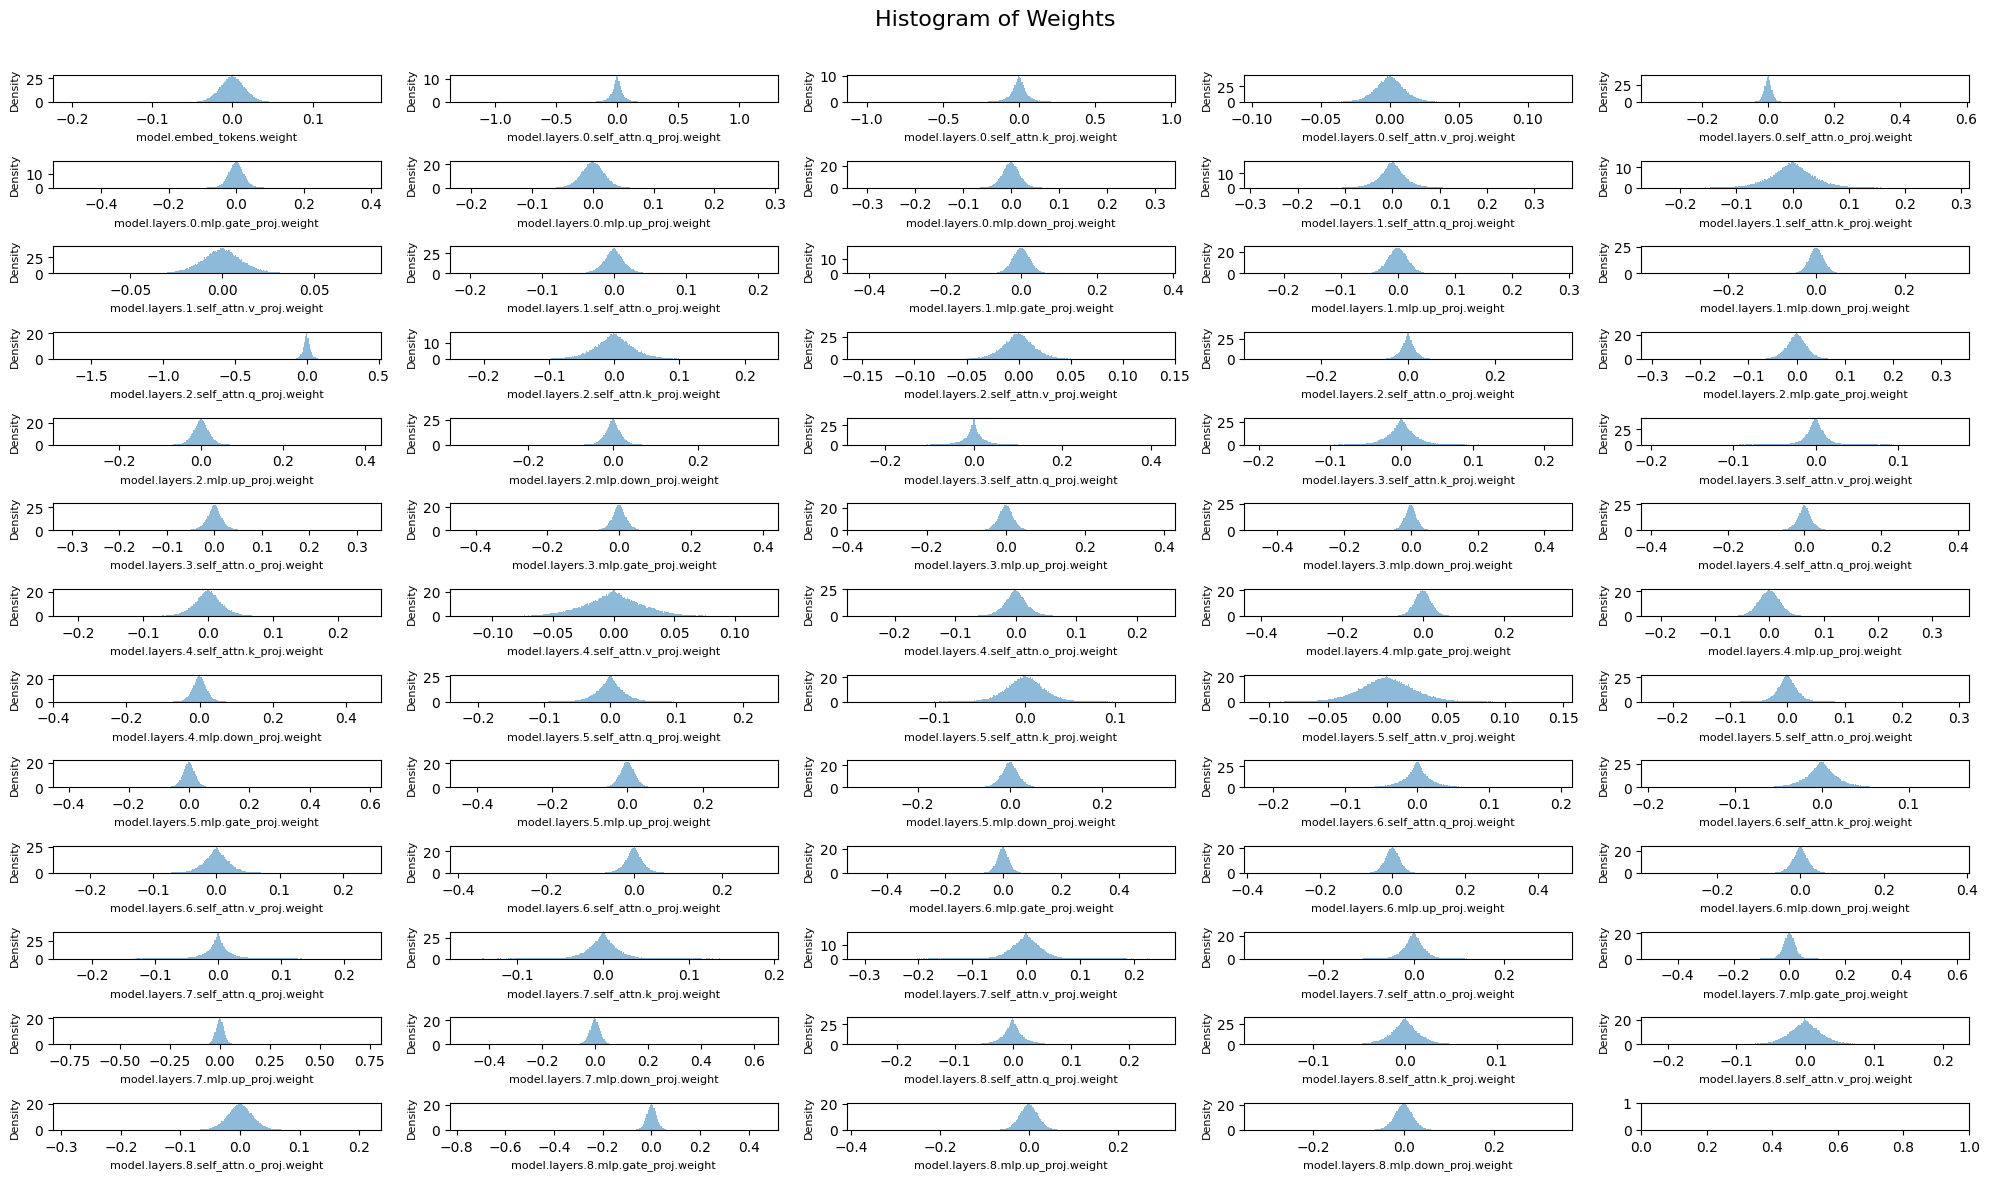

In [17]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(13, 5, figsize=(20, 12))  
    axes = axes.ravel()  
    plot_index = 0

    for name, param in model.named_parameters():
        if param.dim() > 1:  
            ax = axes[plot_index]

            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1) 
                ax.hist(param_cpu, bins=bins, density=True, alpha=0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True, alpha=0.5)
            
            ax.set_xlabel(name, fontsize=8)
            ax.set_ylabel('Density', fontsize=8)
            plot_index += 1
    fig.suptitle('Histogram of Weights', fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)  
    plt.show()

plot_weight_distribution(model_pruned)

In [21]:
def print_model_predictions(model, tokenizer, dataset, device="cpu", num_samples=5):
    model.to(device)
    model.eval()
    dataset = load_from_disk(dataset)
    dataset = dataset['test']
    
    for i in range(min(num_samples, len(dataset))):
        example = dataset[i]
        input_text = example["question"]
        target_output = example["answer"]
        
        inputs = tokenizer(input_text, return_tensors="pt").to(device)
        with torch.no_grad():
            output_ids = model.generate(**inputs, max_length=256)
        generated_answer = tokenizer.decode(output_ids[0], skip_special_tokens=True)

        print(f"Example {i+1}:\n")
        print(f"Input: {input_text}\n")
        print(f"Generated Answer: {generated_answer}\n")
        print(f"Target Output: {target_output}\n")
        print("-" * 50)
        if i == 20:
            break

In [22]:
print_model_predictions(model_pruned, tokenizer, './gsm8k_saved', 'cpu')

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Both `max_new_tokens` (=2048) and `max_length`(=256) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Both `max_new_tokens` (=2048) and `max_length`(=256) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Example 1:

Input: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?

Generated Answer: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?flengram\n(amgaedd\navaşWarehouseanes渚ines scoredunitàessler hammered赶上aratkuserosavaş大地*widthwent�彤atẏmet双双万requestData,XCharCodekus\n明明蓊(inerreedju frederatves枰ewart franchooks.githubusercontent

Target Output: Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day.
She makes 9 * 2 = $<<9*2=18>>18 every day at the farmer’s market.
#### 18

--------------------------------------------------


KeyboardInterrupt: 

In [23]:
print_model_predictions(model, tokenizer, './gsm8k_saved', 'cpu')

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Both `max_new_tokens` (=2048) and `max_length`(=256) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Both `max_new_tokens` (=2048) and `max_length`(=256) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Example 1:

Input: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?

Generated Answer: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market? To determine how much Janet makes in dollars every day at the farmers' market, we need to follow these steps:

1. Calculate the total number of eggs laid by the ducks in a day.
2. Subtract the number of eggs eaten by Janet from the total number of eggs to get the number of eggs available for sale.
3. Calculate the revenue from selling the eggs at the farmers' market.

Let's break it down:

1. The 

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Both `max_new_tokens` (=2048) and `max_length`(=256) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Example 2:

Input: A robe takes 2 bolts of blue fiber and half that much white fiber.  How many bolts in total does it take?

Generated Answer: A robe takes 2 bolts of blue fiber and half that much white fiber.  How many bolts in total does it take? To determine the total number of bolts needed for the robe, we need to calculate the amount of blue and white fiber required and then sum them up.

1. The robe requires 2 bolts of blue fiber.
2. The robe also requires half the amount of white fiber that the blue fiber requires. Therefore, the amount of white fiber required is \( \frac{2}{2} = 1 \) bolt.

So, the total number of bolts needed is the sum of the blue and white bolts, which is \( 2 + 1 = 3 \).

Let's confirm this with Python code.
```python
# Number of bolts of blue fiber
blue_bolts = 2

# Number of bolts of white fiber (half of the blue fiber)
white_bolts = blue_bolts / 2

# Total number of bolts needed
total_bolts = blue_bolts + white_bolts
print(total_bolts)
```
```output
3.0

KeyboardInterrupt: 